# code adapted from 

/code/MNF/notebooks/STRING_Data_11.5/testAlphafold_inDifferentPhyla_visulisation_analysis.ipynb

In [1]:

#@title Input protein sequence(s), then hit `Runtime` -> `Run all`

#@title Input protein sequence(s), then hit `Runtime` -> `Run all`

import os
import shutil
import re
import hashlib
import random
import sys
import pickle
import glob
import math
import pandas as pd
import numpy as np
import json
import logging
import time 

from Bio import AlignIO

from pathlib import Path
import matplotlib.pyplot as plt
import importlib_metadata
from pathlib import Path
import zipfile


import argparse


import multiprocessing as mp
import seaborn as sns 






In [2]:
%reload_ext autoreload
%autoreload 2


sys.path.append('../src/utilities')




#from  IntergrateBestHomologousPPCoEvo_unNameSorted import getMetaFrame_withHighDCA
# from read_benchmark_tableformatfile import getMetaFrame_withHighDCA
from ROC_curve import DCA_RocCurve
from ROC_curve import DCA_RocCurve_fromDataframe
from ROC_curve import Random_RocCurve

# from parse_AlphaFold_output import get_interprotein_cm_from_pdb
from parse_AlphaFold_output import get_interprotein_mincm_from_pdb
# from parse_AlphaFold_output import get_interprotein_contactprob_from_processedalphafoldnpz
from parse_AlphaFold_output import get_interprotein_maxcontactprob_from_processedalphafoldnpz
# from parse_AlphaFold_output import simple_precision
# from parse_AlphaFold_output import get_interprotein_contactprob_from_alphafold_distogram


from pdb_benchmark import get_STRING1105_pdb_interact
from pdb_benchmark import get_filter_pdbBenchmark
from pdb_benchmark import add_pdbstatus

In [3]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/"

In [4]:

pdb_interact_PPs,pdb_complex_PPs=get_STRING1105_pdb_interact(pdb_interact_filename=f"{notebookData_folder}STRING_derived_v11.5/pdb/pdb_interact.tsv",
                                retrieve_spe=511145,)

print(len(pdb_interact_PPs),len(pdb_complex_PPs))



len of intersection: 309
414 3243


# level 2 common pps  collect contact12 and pdb data to see if i got correct output 


In [5]:

EggNOG_maxLevel="2"
currentSpe_TaxID="511145"

CoEvo_data_folder=f"{notebookData_folder}PPI_Coevolution/CoEvo_data_STRING11.5/"
EggNog2_meta_frame_path=f"{CoEvo_data_folder}AllLevel_testPhylaEffectSamePosandNeg_Benchmark/SamePosandNeg_STRING115EggNog{EggNOG_maxLevel}Spe511145.benchmark"


EggNog2_allPPI_allInfo_frame=pd.read_csv(EggNog2_meta_frame_path,header=0,index_col=None, sep="\t")
# getMetaFrame_withHighDCA(EggNOG_maxLevel=EggNOG_mxaxLevel,currentSpe_TaxID=currentSpe_TaxID,
#                                                       STRING_Version="11.5",DCA_thres=0,
#                                                benchmark_suffix="testPhylaEffectSamePPs_Benchmark/",
#                                                sort_frame=False,
#                                              CoEvo_data_folder=CoEvo_data_folder)

print(EggNog2_allPPI_allInfo_frame.shape)

EggNog2_allPPI_lenInfo_list=EggNog2_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()
EggNog2_allPPI_lenInfo_dict={(p1,p2):[l1,l2] for p1,p2, l1,l2 in EggNog2_allPPI_lenInfo_list}


EggNog2_allPPI_allInfo_list=EggNog2_allPPI_allInfo_frame.values.tolist()
EggNog2_allPPI_allInfo_dict={(l[0],l[1]):l[2:] for l in EggNog2_allPPI_allInfo_list}


EggNog2_output_path=f"{notebookData_folder}colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_{currentSpe_TaxID}_EggNOGmaxLeve{EggNOG_maxLevel}/"

EggNog2_figure_prefiex=""

model_key='model_3'

print(EggNog2_output_path)

(19669, 9)
/mnt/mnemo6/tao/notebook_data/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve2/


In [6]:
%%time
#unrelaxed_protein_file=output_path+figure_prefiex+test_P1+"and"+test_P2+"_unrelaxed_rank_1_"+model_key+".pdb"

if not os.path.exists(EggNog2_output_path+"cached_result/EggNog2_interprotein_maxprob12_dict.pickle") :

    EggNog2_existed_pdb_files=glob.glob(EggNog2_output_path+EggNog2_figure_prefiex+"*"+".custom_unrelaxed_rank_1_"+model_key+".pdb")
    print(len(EggNog2_existed_pdb_files))

    EggNog2_base_pdb_files=[os.path.basename(f) for f in EggNog2_existed_pdb_files]
    EggNog2_p=re.compile("(.*).custom_unrelaxed_rank_1_model_3.pdb")
    EggNog2_base_pdb_files=[EggNog2_p.search(f).group(1) for f in EggNog2_base_pdb_files]
    EggNog2_base_pdb_PPs=[tuple(f.split("and")) for f in EggNog2_base_pdb_files]



    EggNog2_argument_toget_interprotein_prob12=[[EggNog2_output_path+EggNog2_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(EggNog2_base_pdb_PPs[i])+EggNog2_allPPI_lenInfo_dict[EggNog2_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog2_existed_pdb_files) if EggNog2_base_pdb_PPs[i] in EggNog2_allPPI_lenInfo_dict]
    print(len(EggNog2_argument_toget_interprotein_prob12))
    pool=mp.Pool(30)
    EggNog2_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,EggNog2_argument_toget_interprotein_prob12)
    pool.close() 
    EggNog2_interprotein_maxprob12_dict={(p1,p2):interprotein_maxprob12 for p1, p2, interprotein_maxprob12 in EggNog2_interprotein_maxprob12_list}
    with open(EggNog2_output_path+"cached_result/EggNog2_interprotein_maxprob12_dict.pickle","wb") as f:
        pickle.dump(EggNog2_interprotein_maxprob12_dict,f)

    EggNog2_argument_toget_interprotein_cm=[[EggNog2_output_path+EggNog2_figure_prefiex,".custom_unrelaxed_rank_1_"+model_key+".pdb",".custom_unrelaxed_rank_1_"+model_key+"_contactmap.npz"]+list(EggNog2_base_pdb_PPs[i])+EggNog2_allPPI_lenInfo_dict[EggNog2_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog2_existed_pdb_files) if EggNog2_base_pdb_PPs[i] in EggNog2_allPPI_lenInfo_dict]
    print(len(EggNog2_argument_toget_interprotein_cm))
    pool=mp.Pool(30)
    EggNog2_interprotein_mincm_list=pool.map(get_interprotein_mincm_from_pdb,EggNog2_argument_toget_interprotein_cm)
    pool.close() 
    EggNog2_interprotein_mincm_dict={(p1,p2):interprotein_mincm for p1, p2, interprotein_mincm in EggNog2_interprotein_mincm_list}
    with open(EggNog2_output_path+"cached_result/EggNog2_interprotein_mincm_dict.pickle","wb") as f:
        pickle.dump(EggNog2_interprotein_mincm_dict,f)
else:

    with open(EggNog2_output_path+"cached_result/EggNog2_interprotein_maxprob12_dict.pickle","rb") as f:
        EggNog2_interprotein_maxprob12_dict=pickle.load(f)
    print(len(EggNog2_interprotein_maxprob12_dict))

    with open(EggNog2_output_path+"cached_result/EggNog2_interprotein_mincm_dict.pickle","rb") as f:
        EggNog2_interprotein_mincm_dict=pickle.load(f)
    print(len(EggNog2_interprotein_mincm_dict))


19669
19669
CPU times: user 31 ms, sys: 2.38 ms, total: 33.4 ms
Wall time: 290 ms


In [7]:
EggNog2_DCA_scores=[(pp,EggNog2_allPPI_allInfo_dict[pp][1]) for pp in EggNog2_interprotein_mincm_dict.keys()]
EggNog2_DCA_scores=sorted(EggNog2_DCA_scores,key=lambda x: x[1],reverse=True)


In [8]:
%%time

EggNog2_minDisAndProb12AndmaxDCAscore=list()
for pp, score in EggNog2_DCA_scores: 
#for pp, interprotein_cm in interprotein_contact_map_dict.items():

    minDis=EggNog2_interprotein_mincm_dict[pp] 
    inverse_minDis=1/minDis
 

    maxProb12=EggNog2_interprotein_maxprob12_dict[pp] 
    inverse_maxProb12=1/maxProb12
    
    EggNog2_minDisAndProb12AndmaxDCAscore.append([pp[0],pp[1],
                                                EggNog2_allPPI_allInfo_dict[pp][0],
                                               EggNog2_allPPI_allInfo_dict[pp][1],
                                               minDis,
                                                inverse_minDis,
                                                  maxProb12,
                                                  inverse_maxProb12,
                                              ])
    
    # print(pp,
    #       EggNog2_interprotein_cm_flattensorted[:1],
    #       EggNog2_interprotein_prob12_flattensorted[-1:],
    #       allPPI_allInfo_dict[pp])
EggNog2_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(EggNog2_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","maxDCA","minDis","inverse_minDis","maxProb12","inverse_maxProb12"])


# before 1 minuste ,
# now
# CPU times: user 4min 18s, sys: 0 ns, total: 4min 18s
# Wall time: 4min 18s

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 149 ms


In [9]:
EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in EggNog2_minDisAndProb12AndmaxDCAscore_frame["status"]]
EggNog2_minDisAndProb12AndmaxDCAscore_frame

,pro1,pro2,status,maxDCA,minDis,inverse_minDis,maxProb12,inverse_maxProb12,status_numeric
0,511145.b2606,511145.b3310,P,6.6053,4.480272,0.223201,0.999925,1.000075,1
1,511145.b3186,511145.b3301,P,4.8153,7.759840,0.128869,0.905007,1.104964,1
2,511145.b1716,511145.b3186,P,4.5621,5.256681,0.190234,0.999849,1.000151,1
3,511145.b3307,511145.b3321,P,4.3781,4.520319,0.221223,0.999643,1.000357,1
4,511145.b3298,511145.b3316,P,4.2903,5.008636,0.199655,0.999570,1.000430,1
...,...,...,...,...,...,...,...,...,...
19664,511145.b0089,511145.b1300,N,0.3163,19.300571,0.051812,0.051809,19.301780,0
19665,511145.b1415,511145.b1914,N,0.3081,28.430996,0.035173,0.052322,19.112336,0
19666,511145.b1914,511145.b2661,N,0.3022,45.144173,0.022151,0.018787,53.229119,0
19667,511145.b2511,511145.b3811,N,0.2801,16.774254,0.059615,0.169497,5.899807,0


In [10]:
%%time
pdb_interact_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)
CPU times: user 11.2 s, sys: 178 µs, total: 11.2 s
Wall time: 11.2 s


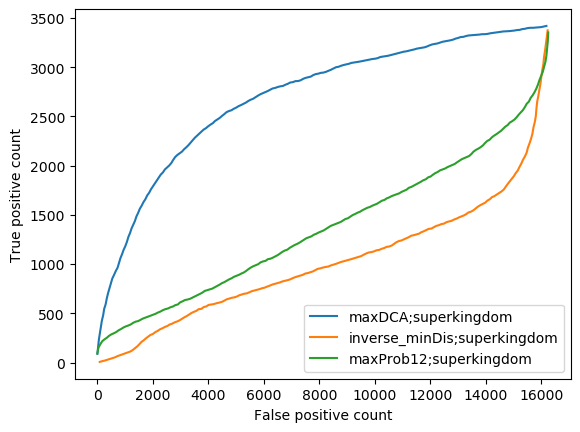

CPU times: user 258 ms, sys: 2.66 ms, total: 260 ms
Wall time: 260 ms


In [11]:
%%time 
step =100   #10
DCA_RocCurve_fromDataframe(DataFrame=EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="superkingdom")

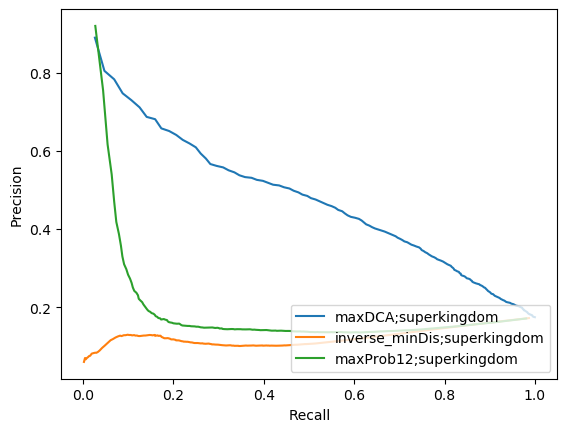

CPU times: user 202 ms, sys: 2.5 ms, total: 205 ms
Wall time: 204 ms


In [12]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="rate",
                          step=step,
                          plotType="PR",
                          legend_suffix="superkingdom")

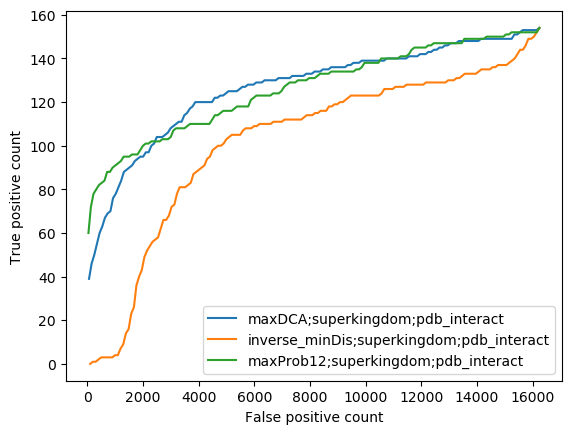

CPU times: user 222 ms, sys: 484 µs, total: 222 ms
Wall time: 222 ms


In [13]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=pdb_interact_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="superkingdom;pdb_interact")

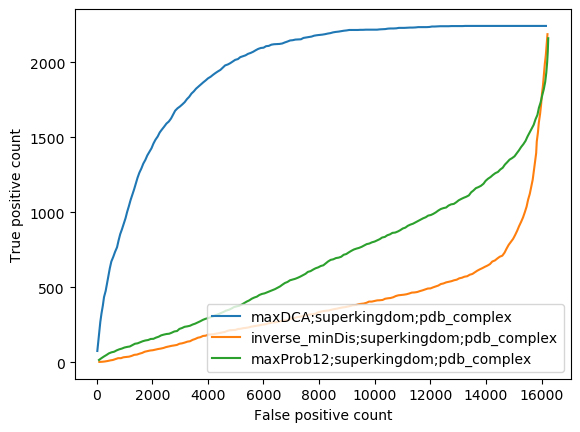

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 179 ms


In [14]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="superkingdom;pdb_complex")

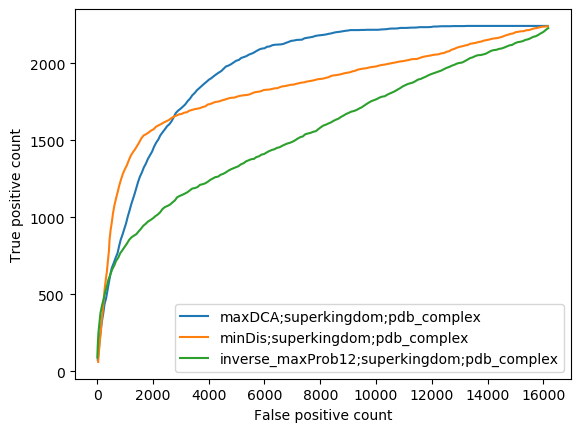

CPU times: user 209 ms, sys: 11.9 ms, total: 221 ms
Wall time: 220 ms


In [15]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","minDis","inverse_maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="superkingdom;pdb_complex")

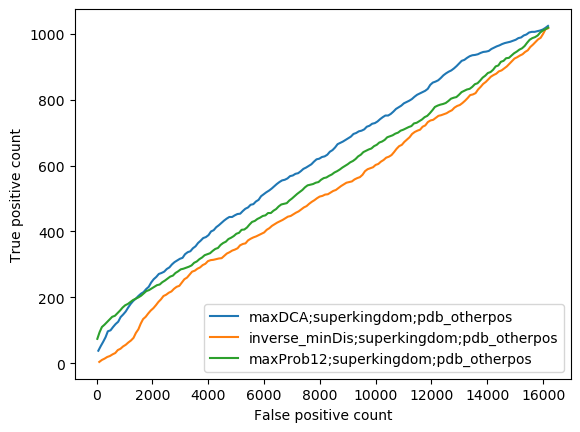

CPU times: user 189 ms, sys: 2.03 ms, total: 191 ms
Wall time: 190 ms


In [16]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_otherpos_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="superkingdom;pdb_otherpos")

# level 1224 common pps  collect contact12 and pdb data to see if i got correct output 


In [17]:

EggNOG_maxLevel="1224"
currentSpe_TaxID="511145"

# CoEvo_data_folder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/"
EggNog1224_meta_frame_path=f"{CoEvo_data_folder}AllLevel_testPhylaEffectSamePosandNeg_Benchmark/SamePosandNeg_STRING115EggNog{EggNOG_maxLevel}Spe511145.benchmark"


EggNog1224_output_path=f"{notebookData_folder}colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_{currentSpe_TaxID}_EggNOGmaxLeve{EggNOG_maxLevel}/"

EggNog1224_figure_prefiex=""

model_key='model_3'

EggNog1224_allPPI_allInfo_frame=pd.read_csv(EggNog1224_meta_frame_path,header=0,index_col=None, sep="\t")
# getMetaFrame_withHighDCA(EggNOG_maxLevel=EggNOG_mxaxLevel,currentSpe_TaxID=currentSpe_TaxID,
#                                                       STRING_Version="11.5",DCA_thres=0,
#                                                benchmark_suffix="testPhylaEffectSamePPs_Benchmark/",
#                                                sort_frame=False,
#                                              CoEvo_data_folder=CoEvo_data_folder)

print(EggNog1224_allPPI_allInfo_frame.shape)

EggNog1224_allPPI_lenInfo_list=EggNog1224_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()
EggNog1224_allPPI_lenInfo_dict={(p1,p2):[l1,l2] for p1,p2, l1,l2 in EggNog1224_allPPI_lenInfo_list}


EggNog1224_allPPI_allInfo_list=EggNog1224_allPPI_allInfo_frame.values.tolist()
EggNog1224_allPPI_allInfo_dict={(l[0],l[1]):l[2:] for l in EggNog1224_allPPI_allInfo_list}



(19669, 9)


In [18]:
%%time 
# why this step become so slnow 
#unrelaxed_protein_file=output_path+figure_prefiex+test_P1+"and"+test_P2+"_unrelaxed_rank_1_"+model_key+".pdb"

if not os.path.exists(EggNog1224_output_path+"cached_result/EggNog1224_interprotein_maxprob12_dict.pickle"):
    EggNog1224_existed_pdb_files=glob.glob(EggNog1224_output_path+EggNog1224_figure_prefiex+"*"+".custom_unrelaxed_rank_1_"+model_key+".pdb")
    print(len(EggNog1224_existed_pdb_files),EggNog1224_existed_pdb_files[0])

    EggNog1224_base_pdb_files=[os.path.basename(f) for f in EggNog1224_existed_pdb_files]
    EggNog1224_p=re.compile("(.*).custom_unrelaxed_rank_1_model_3.pdb")
    EggNog1224_base_pdb_files=[EggNog1224_p.search(f).group(1) for f in EggNog1224_base_pdb_files]
    EggNog1224_base_pdb_PPs=[tuple(f.split("and")) for f in EggNog1224_base_pdb_files]




    EggNog1224_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(EggNog1224_base_pdb_PPs[i])+EggNog1224_allPPI_lenInfo_dict[EggNog1224_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog1224_existed_pdb_files) if EggNog1224_base_pdb_PPs[i] in EggNog1224_allPPI_lenInfo_dict]
    print(len(EggNog1224_argument_toget_interprotein_prob12))
    pool=mp.Pool(30)
    EggNog1224_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,EggNog1224_argument_toget_interprotein_prob12)
    pool.close() 
    EggNog1224_interprotein_maxprob12_dict={(p1,p2):interprotein_maxprob12 for p1, p2, interprotein_maxprob12 in EggNog1224_interprotein_maxprob12_list}
    with open(EggNog1224_output_path+"cached_result/EggNog1224_interprotein_maxprob12_dict.pickle","wb") as f:
        pickle.dump(EggNog1224_interprotein_maxprob12_dict,f)


    EggNog1224_argument_toget_interprotein_cm=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_unrelaxed_rank_1_"+model_key+".pdb",".custom_unrelaxed_rank_1_"+model_key+"_contactmap.npz"]+list(EggNog1224_base_pdb_PPs[i])+EggNog1224_allPPI_lenInfo_dict[EggNog1224_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog1224_existed_pdb_files) if EggNog1224_base_pdb_PPs[i] in EggNog1224_allPPI_lenInfo_dict]
    print(len(EggNog1224_argument_toget_interprotein_cm))
    pool=mp.Pool(30)
    EggNog1224_interprotein_mincm_list=pool.map(get_interprotein_mincm_from_pdb,EggNog1224_argument_toget_interprotein_cm)
    pool.close() 
    EggNog1224_interprotein_mincm_dict={(p1,p2):interprotein_mincm for p1, p2, interprotein_mincm in EggNog1224_interprotein_mincm_list}
    with open(EggNog1224_output_path+"cached_result/EggNog1224_interprotein_mincm_dict.pickle","wb") as f:
        pickle.dump(EggNog1224_interprotein_mincm_dict,f)
else:
    with open(EggNog1224_output_path+"cached_result/EggNog1224_interprotein_maxprob12_dict.pickle","rb") as f:
        EggNog1224_interprotein_maxprob12_dict=pickle.load(f)
    print(len(EggNog1224_interprotein_maxprob12_dict))
    with open(EggNog1224_output_path+"cached_result/EggNog1224_interprotein_mincm_dict.pickle","rb") as f:
        EggNog1224_interprotein_mincm_dict=pickle.load(f)
    print(len(EggNog1224_interprotein_mincm_dict))

19669
19669
CPU times: user 26.6 ms, sys: 3.22 ms, total: 29.8 ms
Wall time: 50.4 ms


In [19]:
EggNog1224_DCA_scores=[(pp,EggNog1224_allPPI_allInfo_dict[pp][1]) for pp in EggNog1224_interprotein_mincm_dict.keys()]
EggNog1224_DCA_scores=sorted(EggNog1224_DCA_scores,key=lambda x: x[1],reverse=True)


In [20]:
%%time

EggNog1224_minDisAndProb12AndmaxDCAscore=list()
for pp, score in EggNog1224_DCA_scores: 
#for pp, interprotein_cm in interprotein_contact_map_dict.items():

    minDis=EggNog1224_interprotein_mincm_dict[pp] 
    inverse_minDis=1/minDis
 

    maxProb12=EggNog1224_interprotein_maxprob12_dict[pp] 
    inverse_maxProb12=1/maxProb12
    
    EggNog1224_minDisAndProb12AndmaxDCAscore.append([pp[0],pp[1],
                                                EggNog1224_allPPI_allInfo_dict[pp][0],
                                               EggNog1224_allPPI_allInfo_dict[pp][1],
                                               minDis,
                                                inverse_minDis,
                                                  maxProb12,
                                                  inverse_maxProb12,
                                              ])
    
    # print(pp,
    #       EggNog1224_interprotein_cm_flattensorted[:1],
    #       EggNog1224_interprotein_prob12_flattensorted[-1:],
    #       allPPI_allInfo_dict[pp])
EggNog1224_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(EggNog1224_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","maxDCA","minDis","inverse_minDis","maxProb12","inverse_maxProb12"])


# before 1 minuste ,
# now
# CPU times: user 4min 18s, sys: 0 ns, total: 4min 18s
# Wall time: 4min 18s

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 127 ms


In [21]:
EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status"]]
EggNog1224_minDisAndProb12AndmaxDCAscore_frame

,pro1,pro2,status,maxDCA,minDis,inverse_minDis,maxProb12,inverse_maxProb12,status_numeric
0,511145.b3312,511145.b3318,P,7.3076,5.593788,0.178770,0.992320,1.007739,1
1,511145.b1089,511145.b1716,P,6.6822,11.651998,0.085822,0.478006,2.092022,1
2,511145.b1089,511145.b3294,P,5.6763,4.786435,0.208924,0.999443,1.000558,1
3,511145.b3736,511145.b3738,P,4.4504,3.972518,0.251730,0.788069,1.268924,1
4,511145.b0721,511145.b0722,P,4.4006,5.552352,0.180104,0.999949,1.000051,1
...,...,...,...,...,...,...,...,...,...
19664,511145.b0831,511145.b1285,N,0.4364,34.925655,0.028632,0.071126,14.059570,0
19665,511145.b1525,511145.b3650,N,0.4285,18.713131,0.053438,0.016440,60.825885,0
19666,511145.b0054,511145.b1126,N,0.4094,8.807862,0.113535,0.127481,7.844283,0
19667,511145.b1525,511145.b3778,N,0.4048,10.931238,0.091481,0.048551,20.596948,0


In [22]:
pdb_interact_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)


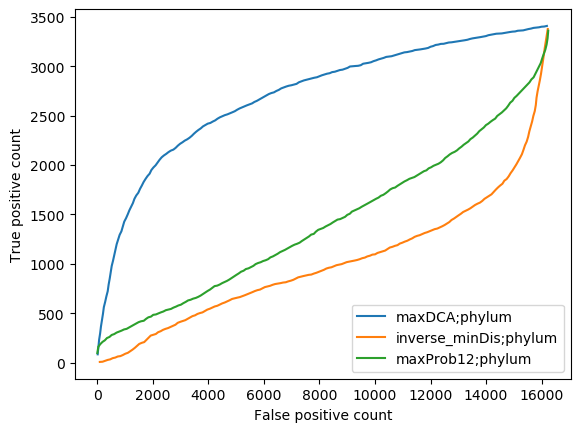

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 184 ms


In [23]:
%%time 
step =100   #10
DCA_RocCurve_fromDataframe(DataFrame=EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="phylum")

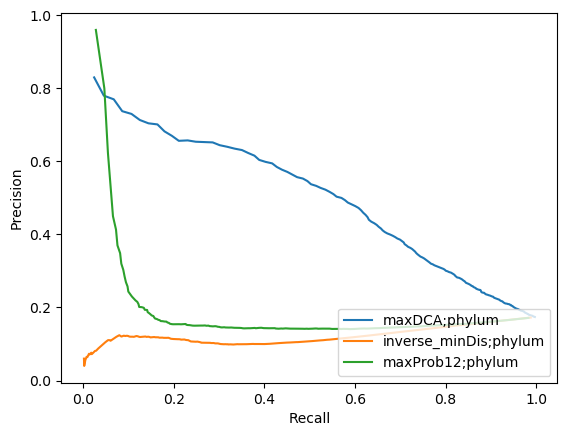

CPU times: user 145 ms, sys: 109 µs, total: 145 ms
Wall time: 144 ms


In [24]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="rate",
                          step=step,
                          plotType="PR",
                          legend_suffix="phylum")

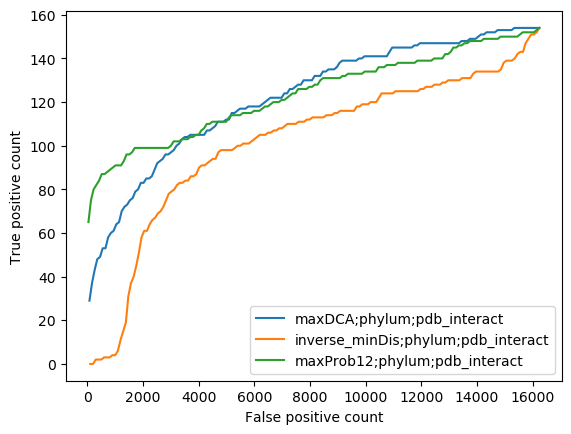

CPU times: user 153 ms, sys: 4.25 ms, total: 157 ms
Wall time: 157 ms


In [25]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=pdb_interact_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="phylum;pdb_interact")

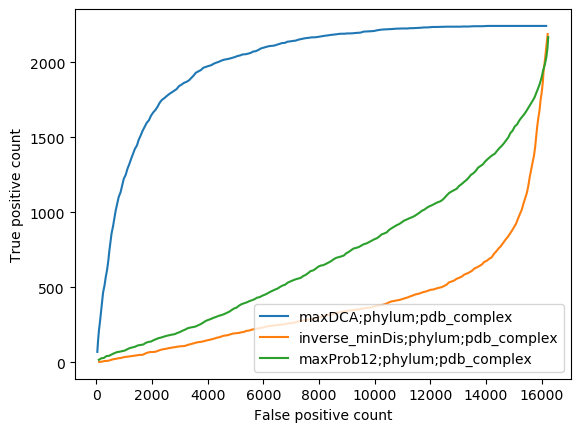

CPU times: user 152 ms, sys: 3.97 ms, total: 156 ms
Wall time: 156 ms


In [26]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="phylum;pdb_complex")

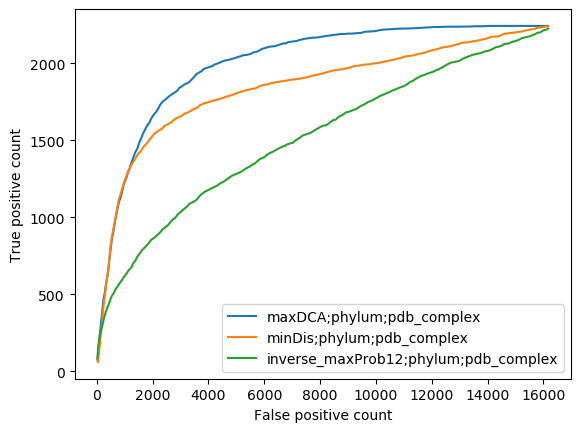

CPU times: user 153 ms, sys: 2.69 ms, total: 155 ms
Wall time: 154 ms


In [27]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","minDis","inverse_maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="phylum;pdb_complex")

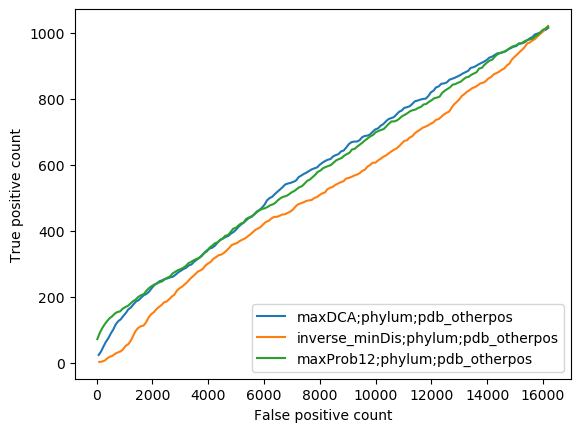

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 155 ms


In [28]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_otherpos_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="phylum;pdb_otherpos")

# level 1236 common pps  collect contact12 and pdb data to see if i got correct output 


In [29]:

EggNOG_maxLevel="1236"
currentSpe_TaxID="511145"

# CoEvo_data_folder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/"
EggNog1236_meta_frame_path=f"{CoEvo_data_folder}AllLevel_testPhylaEffectSamePosandNeg_Benchmark/SamePosandNeg_STRING115EggNog{EggNOG_maxLevel}Spe511145.benchmark"


EggNog1236_output_path=f"{notebookData_folder}colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_{currentSpe_TaxID}_EggNOGmaxLeve{EggNOG_maxLevel}/"

EggNog1236_figure_prefiex=""

model_key='model_3'

EggNog1236_allPPI_allInfo_frame=pd.read_csv(EggNog1236_meta_frame_path,header=0,index_col=None, sep="\t")
# getMetaFrame_withHighDCA(EggNOG_maxLevel=EggNOG_mxaxLevel,currentSpe_TaxID=currentSpe_TaxID,
#                                                       STRING_Version="11.5",DCA_thres=0,
#                                                benchmark_suffix="testPhylaEffectSamePPs_Benchmark/",
#                                                sort_frame=False,
#                                              CoEvo_data_folder=CoEvo_data_folder)

print(EggNog1236_allPPI_allInfo_frame.shape)

EggNog1236_allPPI_lenInfo_list=EggNog1236_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()
EggNog1236_allPPI_lenInfo_dict={(p1,p2):[l1,l2] for p1,p2, l1,l2 in EggNog1236_allPPI_lenInfo_list}


EggNog1236_allPPI_allInfo_list=EggNog1236_allPPI_allInfo_frame.values.tolist()
EggNog1236_allPPI_allInfo_dict={(l[0],l[1]):l[2:] for l in EggNog1236_allPPI_allInfo_list}



(19669, 9)


In [30]:
%%time
#unrelaxed_protein_file=output_path+figure_prefiex+test_P1+"and"+test_P2+"_unrelaxed_rank_1_"+model_key+".pdb"

if not os.path.exists(EggNog1236_output_path+"cached_result/EggNog1236_interprotein_maxprob12_dict.pickle"):
    EggNog1236_existed_pdb_files=glob.glob(EggNog1236_output_path+EggNog1236_figure_prefiex+"*"+".custom_unrelaxed_rank_1_"+model_key+".pdb")
    print(len(EggNog1236_existed_pdb_files),EggNog1236_existed_pdb_files[0])

    EggNog1236_base_pdb_files=[os.path.basename(f) for f in EggNog1236_existed_pdb_files]
    EggNog1236_p=re.compile("(.*).custom_unrelaxed_rank_1_model_3.pdb")
    EggNog1236_base_pdb_files=[EggNog1236_p.search(f).group(1) for f in EggNog1236_base_pdb_files]
    EggNog1236_base_pdb_PPs=[tuple(f.split("and")) for f in EggNog1236_base_pdb_files]


    EggNog1236_argument_toget_interprotein_prob12=[[EggNog1236_output_path+EggNog1236_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(EggNog1236_base_pdb_PPs[i])+EggNog1236_allPPI_lenInfo_dict[EggNog1236_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog1236_existed_pdb_files) if EggNog1236_base_pdb_PPs[i] in EggNog1236_allPPI_lenInfo_dict]
    print(len(EggNog1236_argument_toget_interprotein_prob12))
    pool=mp.Pool(30)
    EggNog1236_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,EggNog1236_argument_toget_interprotein_prob12)
    pool.close() 
    EggNog1236_interprotein_maxprob12_dict={(p1,p2):interprotein_maxprob12 for p1, p2, interprotein_maxprob12 in EggNog1236_interprotein_maxprob12_list}
    with open(EggNog1236_output_path+"cached_result/EggNog1236_interprotein_maxprob12_dict.pickle","wb") as f:
        pickle.dump(EggNog1236_interprotein_maxprob12_dict,f)

    EggNog1236_argument_toget_interprotein_cm=[[EggNog1236_output_path+EggNog1236_figure_prefiex,".custom_unrelaxed_rank_1_"+model_key+".pdb",".custom_unrelaxed_rank_1_"+model_key+"_contactmap.npz"]+list(EggNog1236_base_pdb_PPs[i])+EggNog1236_allPPI_lenInfo_dict[EggNog1236_base_pdb_PPs[i]] for i, unrelaxed_protein_file in enumerate(EggNog1236_existed_pdb_files) if EggNog1236_base_pdb_PPs[i] in EggNog1236_allPPI_lenInfo_dict]
    print(len(EggNog1236_argument_toget_interprotein_cm))
    pool=mp.Pool(30)
    EggNog1236_interprotein_mincm_list=pool.map(get_interprotein_mincm_from_pdb,EggNog1236_argument_toget_interprotein_cm)
    pool.close() 
    EggNog1236_interprotein_mincm_dict={(p1,p2):interprotein_mincm for p1, p2, interprotein_mincm in EggNog1236_interprotein_mincm_list}
    with open(EggNog1236_output_path+"cached_result/EggNog1236_interprotein_mincm_dict.pickle","wb") as f:
        pickle.dump(EggNog1236_interprotein_mincm_dict,f)
else:
    with open(EggNog1236_output_path+"cached_result/EggNog1236_interprotein_maxprob12_dict.pickle","rb") as f:
        EggNog1236_interprotein_maxprob12_dict=pickle.load(f)
        print(len(EggNog1236_interprotein_maxprob12_dict))
    with open(EggNog1236_output_path+"cached_result/EggNog1236_interprotein_mincm_dict.pickle","rb") as f:
        EggNog1236_interprotein_mincm_dict=pickle.load(f)
        print(len(EggNog1236_interprotein_mincm_dict))
    

19669
19669
CPU times: user 21.2 ms, sys: 4.4 ms, total: 25.6 ms
Wall time: 157 ms


In [31]:
EggNog1236_DCA_scores=[(pp,EggNog1236_allPPI_allInfo_dict[pp][1]) for pp in EggNog1236_interprotein_mincm_dict.keys()]
EggNog1236_DCA_scores=sorted(EggNog1236_DCA_scores,key=lambda x: x[1],reverse=True)


In [32]:
%%time

EggNog1236_minDisAndProb12AndmaxDCAscore=list()
for pp, score in EggNog1236_DCA_scores: 
#for pp, interprotein_cm in interprotein_contact_map_dict.items():

    minDis=EggNog1236_interprotein_mincm_dict[pp] 
    inverse_minDis=1/minDis
 

    maxProb12=EggNog1236_interprotein_maxprob12_dict[pp] 
    inverse_maxProb12=1/maxProb12
    
    EggNog1236_minDisAndProb12AndmaxDCAscore.append([pp[0],pp[1],
                                                EggNog1236_allPPI_allInfo_dict[pp][0],
                                               EggNog1236_allPPI_allInfo_dict[pp][1],
                                               minDis,
                                                inverse_minDis,
                                                  maxProb12,
                                                  inverse_maxProb12,
                                              ])
    
    # print(pp,
    #       EggNog1236_interprotein_cm_flattensorted[:1],
    #       EggNog1236_interprotein_prob12_flattensorted[-1:],
    #       allPPI_allInfo_dict[pp])
EggNog1236_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(EggNog1236_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","maxDCA","minDis","inverse_minDis","maxProb12","inverse_maxProb12"])


# before 1 minuste ,
# now
# CPU times: user 4min 18s, sys: 0 ns, total: 4min 18s
# Wall time: 4min 18s

CPU times: user 94.7 ms, sys: 7.47 ms, total: 102 ms
Wall time: 101 ms


In [33]:
EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status"]]
EggNog1236_minDisAndProb12AndmaxDCAscore_frame

,pro1,pro2,status,maxDCA,minDis,inverse_minDis,maxProb12,inverse_maxProb12,status_numeric
0,511145.b1089,511145.b1716,P,6.4101,8.424450,0.118702,0.277701,3.600990,1
1,511145.b1089,511145.b3294,P,6.0262,4.834486,0.206847,0.999666,1.000334,1
2,511145.b3736,511145.b3738,P,4.8464,4.833402,0.206894,0.823870,1.213784,1
3,511145.b2185,511145.b3936,P,4.6772,7.872704,0.127021,0.422435,2.367228,1
4,511145.b1716,511145.b3186,P,4.6402,5.149380,0.194198,0.999020,1.000981,1
...,...,...,...,...,...,...,...,...,...
19664,511145.b3162,511145.b4221,N,0.4619,76.262665,0.013113,0.135389,7.386145,0
19665,511145.b4221,511145.b4355,N,0.4546,130.044022,0.007690,0.011628,85.997039,0
19666,511145.b3072,511145.b4221,N,0.4456,131.961029,0.007578,0.012903,77.499224,0
19667,511145.b3778,511145.b4221,N,0.4453,65.276421,0.015319,0.076751,13.029166,0


In [34]:
pdb_interact_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)


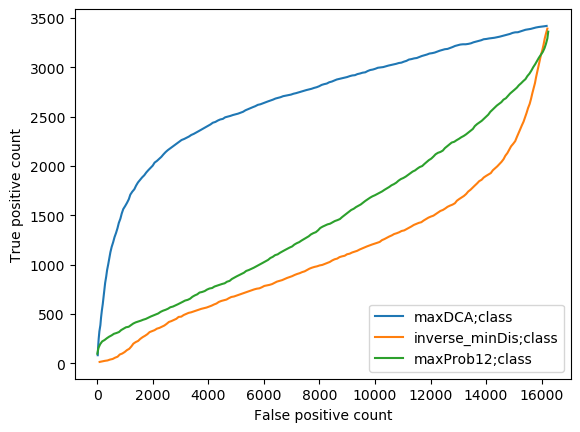

CPU times: user 154 ms, sys: 371 µs, total: 154 ms
Wall time: 154 ms


In [35]:
%%time 
step =100   #10
DCA_RocCurve_fromDataframe(DataFrame=EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="class")

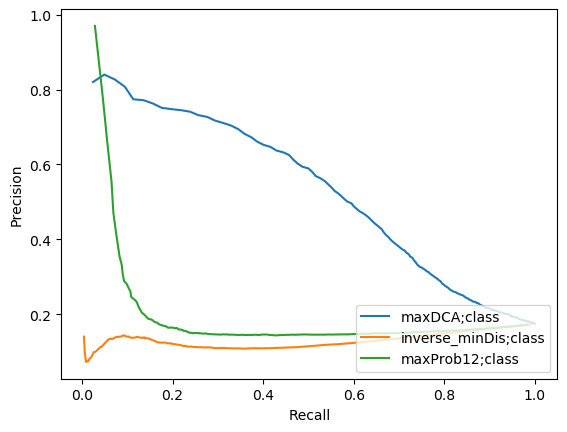

CPU times: user 138 ms, sys: 451 µs, total: 139 ms
Wall time: 138 ms


In [36]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="rate",
                          step=step,
                          plotType="PR",
                          legend_suffix="class")

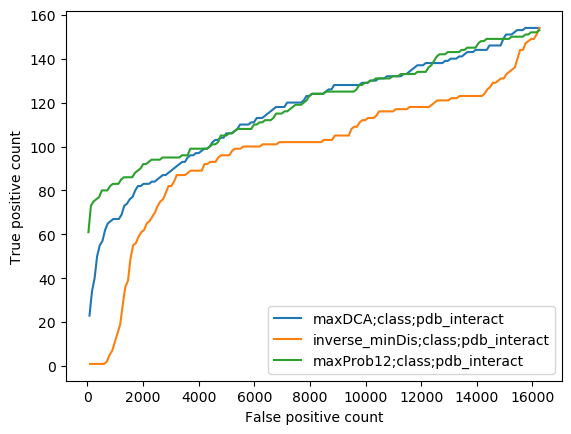

CPU times: user 149 ms, sys: 213 µs, total: 149 ms
Wall time: 149 ms


In [37]:
%%time 
DCA_RocCurve_fromDataframe(DataFrame=pdb_interact_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="class;pdb_interact")

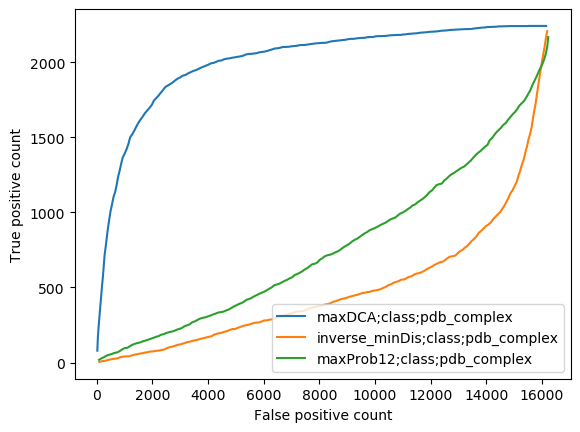

CPU times: user 146 ms, sys: 3.22 ms, total: 149 ms
Wall time: 148 ms


In [38]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="class;pdb_complex")

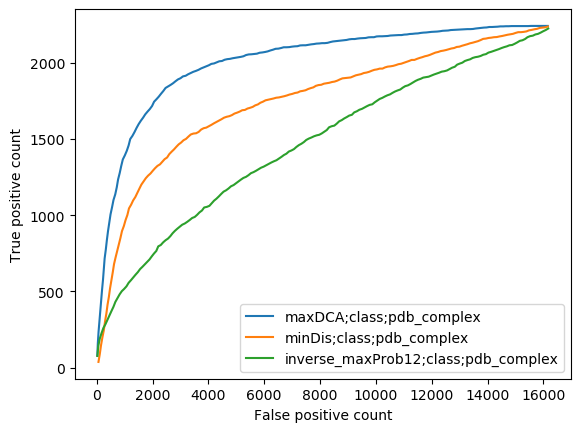

CPU times: user 147 ms, sys: 7.59 ms, total: 154 ms
Wall time: 154 ms


In [39]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_complex_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","minDis","inverse_maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="class;pdb_complex")

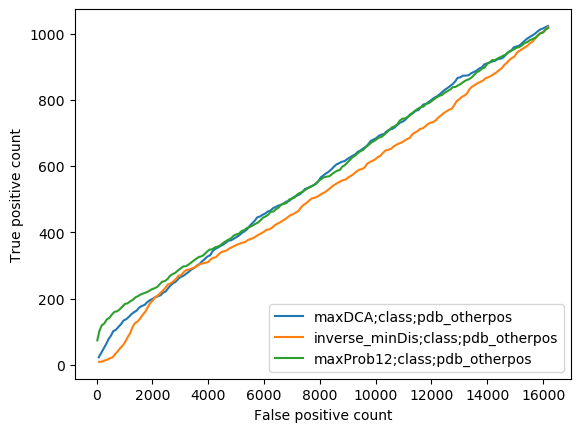

CPU times: user 151 ms, sys: 3.49 ms, total: 154 ms
Wall time: 153 ms


In [40]:
%%time
DCA_RocCurve_fromDataframe(DataFrame=pdb_otherpos_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                          y_label="status_numeric",
                          x_label_list=["maxDCA","inverse_minDis","maxProb12"],
                          count_label="count",
                          step=step,
                          plotType="ROC",
                          legend_suffix="class;pdb_otherpos")

# compare between 1224 and 2, and 1236

first need to find common genes 

In [41]:
EggNog1236_PPs=EggNog1236_interprotein_mincm_dict.keys()
EggNog1224_PPs=EggNog1224_interprotein_mincm_dict.keys()
EggNog2_PPs=EggNog2_interprotein_mincm_dict.keys()

old_common_PPs=list(set(EggNog1236_PPs).intersection(EggNog1224_PPs).intersection(EggNog2_PPs))
old_common_PPs={pp:1 for pp in old_common_PPs}

print(len(EggNog1236_PPs),len(EggNog1224_PPs),len(EggNog2_PPs),len(old_common_PPs),)

19669 19669 19669 19669


In [42]:
old_common_PPs_list=list(old_common_PPs.keys())
old_common_PPs_list=[list(pp) for pp in old_common_PPs_list]

In [43]:
common_PPs=EggNog2_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2"]].values.tolist()# here is keep the order 

In [44]:
sorted(common_PPs)==sorted(old_common_PPs_list)

True

In [45]:
common_PPs={tuple(pp):1 for pp in common_PPs}

In [46]:
pdb_complex_EggNog1224_minDisAndProb12AndmaxDCAscore_frame

,pro1,pro2,status,maxDCA,minDis,inverse_minDis,maxProb12,inverse_maxProb12,status_numeric,pdb_status
10,511145.b2606,511145.b3065,P,3.6462,93.263496,0.010722,0.026121,38.282798,1,pdb_complex
12,511145.b1089,511145.b3306,P,3.4352,54.551373,0.018331,0.014830,67.428738,1,pdb_complex
15,511145.b3165,511145.b3936,P,3.3825,67.995140,0.014707,0.006157,162.408517,1,pdb_complex
18,511145.b3310,511145.b3312,P,3.2889,76.594643,0.013056,0.013652,73.247274,1,pdb_complex
19,511145.b3306,511145.b3985,P,3.2863,74.142654,0.013488,0.064433,15.520073,1,pdb_complex
...,...,...,...,...,...,...,...,...,...,...
19664,511145.b0831,511145.b1285,N,0.4364,34.925655,0.028632,0.071126,14.059570,0,N
19665,511145.b1525,511145.b3650,N,0.4285,18.713131,0.053438,0.016440,60.825885,0,N
19666,511145.b0054,511145.b1126,N,0.4094,8.807862,0.113535,0.127481,7.844283,0,N
19667,511145.b1525,511145.b3778,N,0.4048,10.931238,0.091481,0.048551,20.596948,0,N


In [47]:
EggNog1236_minDisAndProb12AndmaxDCAscore_dict={tuple(l[0:2]):l[2:] for l in EggNog1236_minDisAndProb12AndmaxDCAscore}
EggNog1224_minDisAndProb12AndmaxDCAscore_dict={tuple(l[0:2]):l[2:] for l in EggNog1224_minDisAndProb12AndmaxDCAscore}
EggNog2_minDisAndProb12AndmaxDCAscore_dict={tuple(l[0:2]):l[2:] for l in EggNog2_minDisAndProb12AndmaxDCAscore}
print(len(EggNog1236_minDisAndProb12AndmaxDCAscore_dict),len(EggNog1224_minDisAndProb12AndmaxDCAscore_dict),len(EggNog2_minDisAndProb12AndmaxDCAscore_dict))

# commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore=[list(k)+v for k, v in EggNog1224_minDisAndProb12AndmaxDCAscore_dict.items() if k in common_PPs]
# commonpp_EggNog2_minDisAndProb12AndmaxDCAscore=[list(k)+v for k, v in EggNog2_minDisAndProb12AndmaxDCAscore_dict.items() if k in common_PPs]

# make sure they are in same order 
commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore=[list(k)+EggNog1236_minDisAndProb12AndmaxDCAscore_dict[k] for k in common_PPs ]
commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore=[list(k)+EggNog1224_minDisAndProb12AndmaxDCAscore_dict[k] for k in common_PPs ]
commonpp_EggNog2_minDisAndProb12AndmaxDCAscore=[list(k)+EggNog2_minDisAndProb12AndmaxDCAscore_dict[k] for k in common_PPs]

print(len(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore),len(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore),len(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore))


commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","max DCA","minDis","max inverseMinDis","max prob12","inverse_maxProb12"])

commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","max DCA","minDis","max inverseMinDis","max prob12","inverse_maxProb12"])

commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=pd.DataFrame(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore,
                                                     columns=["pro1","pro2","status","max DCA","minDis","max inverseMinDis","max prob12","inverse_maxProb12"])

print(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
    commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape)


commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status"]]
commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status"]]
commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]=[1 if s=="P" else 0 for s in commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status"]]




19669 19669 19669
19669 19669 19669
(19669, 8) (19669, 8) (19669, 8)


In [48]:
%%time
commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=add_pdbstatus(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                                                     pdb_interact_PPs,pdb_complex_PPs,)

commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=add_pdbstatus(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                                                     pdb_interact_PPs,pdb_complex_PPs,)

commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=add_pdbstatus(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                                                     pdb_interact_PPs,pdb_complex_PPs,)



CPU times: user 6.62 s, sys: 0 ns, total: 6.62 s
Wall time: 6.62 s


In [49]:
commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.head(n=3)

,pro1,pro2,status,max DCA,minDis,max inverseMinDis,max prob12,inverse_maxProb12,status_numeric,pdb_status
0,511145.b0014,511145.b0055,P,0.9972,4.593374,0.217705,0.983704,1.016566,1,other_pos
1,511145.b0014,511145.b0095,P,0.8872,4.830653,0.207011,0.642792,1.555714,1,other_pos
2,511145.b0014,511145.b0436,P,0.6477,20.738075,0.048220,0.164588,6.075763,1,other_pos


In [50]:
# # msastat_lable="num"
# for metapdb_lable in ["max DCA","minDis","max inverseMinDis","max prob12","inverse_maxProb12"]:
#     metapdb_frame=pd.DataFrame(list(zip(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
#                                 commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
#                                commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
#                                commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.pdb_status)),
#                                columns=[f"class",f"phylum",f"superkingdom","pdb_status",]
#                                #columns=[f"1236",f"1224",f"2","pdb_status",]
#                               #columns=[f"1236{metapdb_lable}",f"1224{metapdb_lable}",f"2{metapdb_lable}","pdb_status",]
#                               )
    
#     # here dont show "other_pos" category 
#     #metapdb_frame=metapdb_frame.loc[metapdb_frame["pdb_status"]!="other_pos",:]

#     metapdb_longformat = pd.melt(metapdb_frame, id_vars='pdb_status', value_vars=[f"class",f"phylum",f"superkingdom"])
#     plt.figure(figsize=(8,6))
#     sns.boxplot(data=metapdb_longformat,
#                  y="value",
#                  x="variable",
#                 hue="pdb_status",
#                 # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
#                 hue_order=["N","pdb_complex","pdb_contact"]
#                 )
#     plt.title(metapdb_lable)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()


### Fig .5 

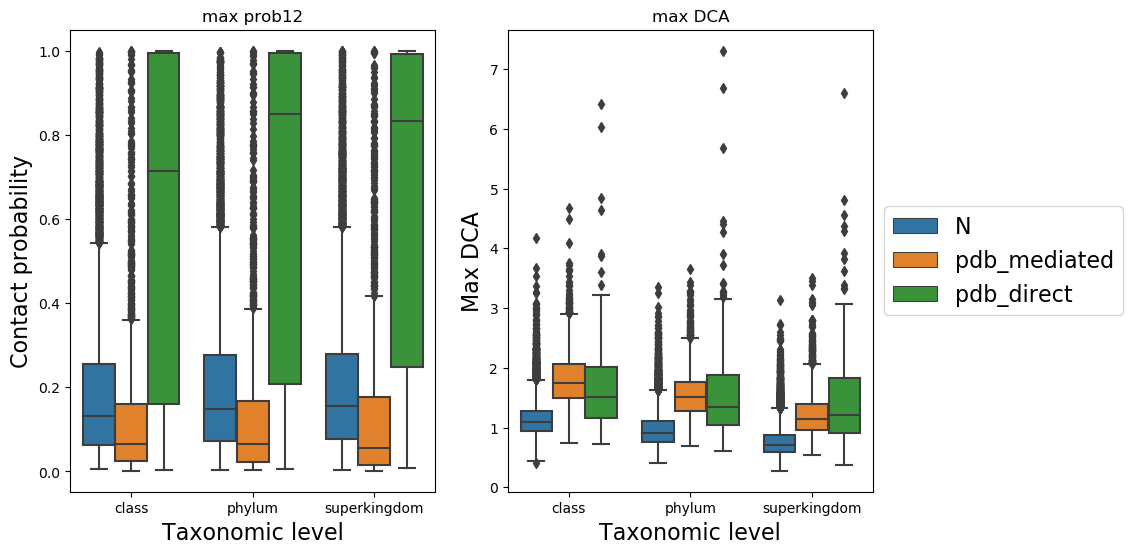

In [51]:
#%%time 

sup_fig2 = plt.figure(figsize=(16,6))


for idx,metapdb_lable in enumerate(["max prob12","max DCA",]):
    metapdb_frame=pd.DataFrame(list(zip(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                                commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.pdb_status)),
                               columns=[f"class",f"phylum",f"superkingdom","pdb_status",]
                               #columns=[f"1236",f"1224",f"2","pdb_status",]
                              #columns=[f"1236{metapdb_lable}",f"1224{metapdb_lable}",f"2{metapdb_lable}","pdb_status",]
                              )
    
    # here dont show "other_pos" category 
    metapdb_frame=metapdb_frame.loc[metapdb_frame["pdb_status"]!="other_pos",:]

    metapdb_longformat = pd.melt(metapdb_frame, id_vars='pdb_status', value_vars=[f"class",f"phylum",f"superkingdom"])
    axA = plt.subplot(1,3,idx+1)
    sns.boxplot(data=metapdb_longformat,
                 y="value",
                 x="variable",
                hue="pdb_status",
                # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
                # hue_order=["N","pdb_complex","pdb_contact"]
                hue_order=["N","pdb_mediated","pdb_direct"]
                )
    axA.set_title(metapdb_lable)
    axA.legend([],[], frameon=False)
    axA.set_xlabel("Taxonomic level",fontsize=16)
    
    if metapdb_lable =="max prob12":
        axA.set_ylabel("Contact probability",fontsize=16)
    elif metapdb_lable =="max DCA":
            axA.set_ylabel("Max DCA",fontsize=16)
        
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
plt.show()

sup_fig2.savefig("/mnt/mnemo5/tao/temp_figures/sup_fig2.pdf", dpi=600)




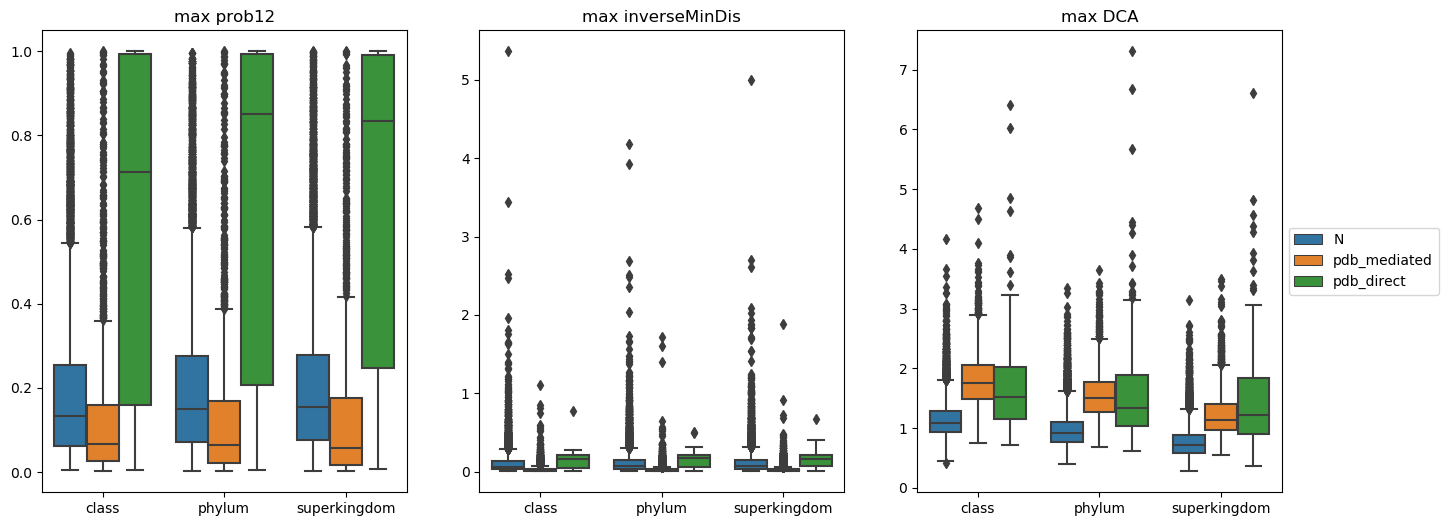

In [52]:
#%%time 

sup_fig2 = plt.figure(figsize=(16,6))


for idx,metapdb_lable in enumerate(["max prob12","max inverseMinDis","max DCA",]):
    metapdb_frame=pd.DataFrame(list(zip(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                                commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.pdb_status)),
                               columns=[f"class",f"phylum",f"superkingdom","pdb_status",]
                               #columns=[f"1236",f"1224",f"2","pdb_status",]
                              #columns=[f"1236{metapdb_lable}",f"1224{metapdb_lable}",f"2{metapdb_lable}","pdb_status",]
                              )
    
    # here dont show "other_pos" category 
    metapdb_frame=metapdb_frame.loc[metapdb_frame["pdb_status"]!="other_pos",:]

    metapdb_longformat = pd.melt(metapdb_frame, id_vars='pdb_status', value_vars=[f"class",f"phylum",f"superkingdom"])
    axA = plt.subplot(1,3,idx+1)
    sns.boxplot(data=metapdb_longformat,
                 y="value",
                 x="variable",
                hue="pdb_status",
                # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
                # hue_order=["N","pdb_complex","pdb_contact"]
                hue_order=["N","pdb_mediated","pdb_direct"]
                )
    axA.set_title(metapdb_lable)
    axA.legend([],[], frameon=False)
    axA.set_xlabel(None)
    axA.set_ylabel(None)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#sup_fig2.savefig("/mnt/mnemo5/tao/temp_figures/sup_fig2.pdf", dpi=600)




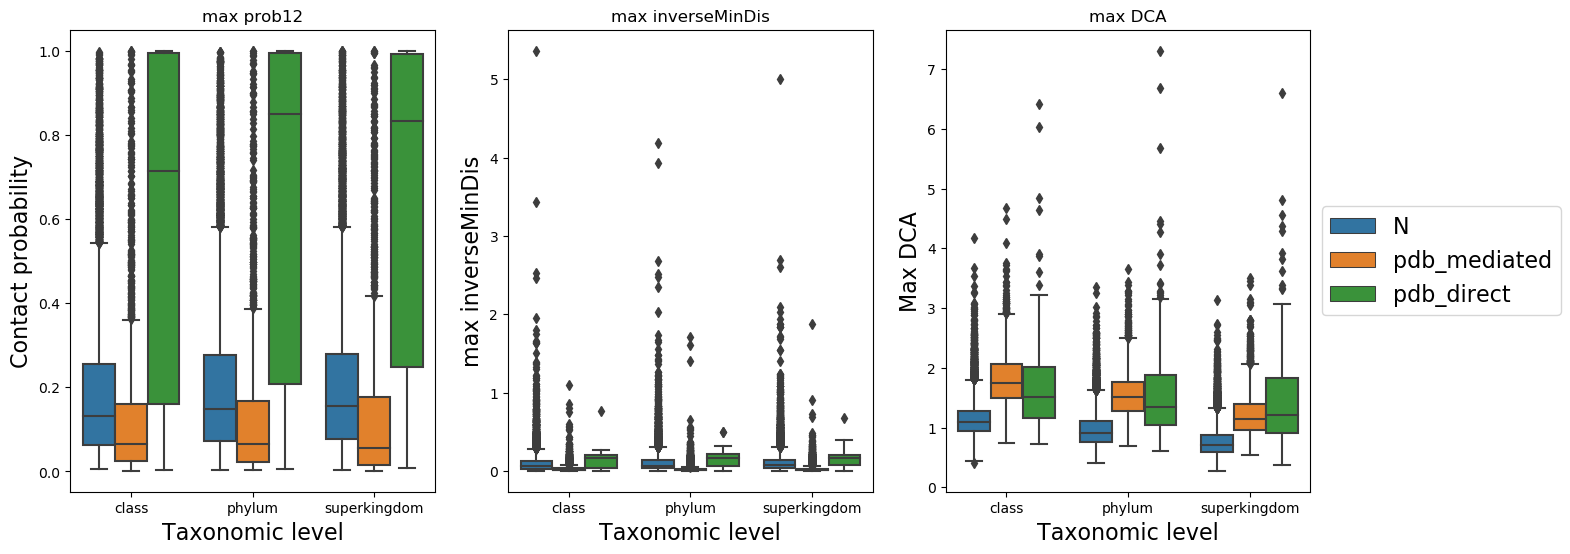

In [53]:
#%%time 

sup_fig2 = plt.figure(figsize=(16,6))


for idx,metapdb_lable in enumerate(["max prob12","max inverseMinDis","max DCA",]):
    metapdb_frame=pd.DataFrame(list(zip(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                                commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame[metapdb_lable],
                               commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.pdb_status)),
                               columns=[f"class",f"phylum",f"superkingdom","pdb_status",]
                               #columns=[f"1236",f"1224",f"2","pdb_status",]
                              #columns=[f"1236{metapdb_lable}",f"1224{metapdb_lable}",f"2{metapdb_lable}","pdb_status",]
                              )
    
    # here dont show "other_pos" category 
    metapdb_frame=metapdb_frame.loc[metapdb_frame["pdb_status"]!="other_pos",:]

    metapdb_longformat = pd.melt(metapdb_frame, id_vars='pdb_status', value_vars=[f"class",f"phylum",f"superkingdom"])
    axA = plt.subplot(1,3,idx+1)
    sns.boxplot(data=metapdb_longformat,
                 y="value",
                 x="variable",
                hue="pdb_status",
                # hue_order=["N","other_pos","pdb_complex","pdb_contact"]
                # hue_order=["N","pdb_complex","pdb_contact"]
                hue_order=["N","pdb_mediated","pdb_direct"]
                )
    axA.set_title(metapdb_lable)
    axA.legend([],[], frameon=False)
    axA.set_xlabel("Taxonomic level",fontsize=16)
    
    if metapdb_lable =="max prob12":
        axA.set_ylabel("Contact probability",fontsize=16)
    elif metapdb_lable =="max inverseMinDis":
            axA.set_ylabel("max inverseMinDis",fontsize=16)
    elif metapdb_lable =="max DCA":
            axA.set_ylabel("Max DCA",fontsize=16)
        
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
plt.show()

#sup_fig2.savefig("/mnt/mnemo5/tao/temp_figures/sup_fig2.pdf", dpi=600)




In [54]:
%%time

pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)
CPU times: user 7.36 s, sys: 10.5 ms, total: 7.37 s
Wall time: 7.37 s


In [55]:
%%time

pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)
CPU times: user 6.99 s, sys: 5.75 ms, total: 7 s
Wall time: 6.99 s


In [56]:
%%time

pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact")

pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex")

pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos")

print(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 16249
(19669, 10) 16403
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 16249
(19669, 10) 17273
(16403, 10) (18491, 10) (17273, 10)
CPU times: user 9.07 s, sys: 28 ms, total: 9.09 s
Wall time: 9.09 s


In [57]:
commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame

,pro1,pro2,status,max DCA,minDis,max inverseMinDis,max prob12,inverse_maxProb12,status_numeric,pdb_status
0,511145.b0014,511145.b0055,P,0.9972,4.593374,0.217705,0.983704,1.016566,1,other_pos
1,511145.b0014,511145.b0095,P,0.8872,4.830653,0.207011,0.642792,1.555714,1,other_pos
2,511145.b0014,511145.b0436,P,0.6477,20.738075,0.048220,0.164588,6.075763,1,other_pos
3,511145.b0014,511145.b2528,P,0.8631,18.151583,0.055092,0.288232,3.469428,1,other_pos
4,511145.b0014,511145.b2614,P,1.3585,4.551888,0.219689,0.939015,1.064945,1,pdb_direct
...,...,...,...,...,...,...,...,...,...,...
19664,511145.b4207,511145.b4473,N,0.6303,5.385330,0.185690,0.432730,2.310908,0,N
19665,511145.b4221,511145.b4355,N,0.4824,120.403702,0.008305,0.009484,105.445407,0,N
19666,511145.b4221,511145.b4389,N,0.6602,49.712971,0.020115,0.119791,8.347864,0,N
19667,511145.b4245,511145.b4355,N,0.4696,32.440666,0.030826,0.019379,51.603383,0,N


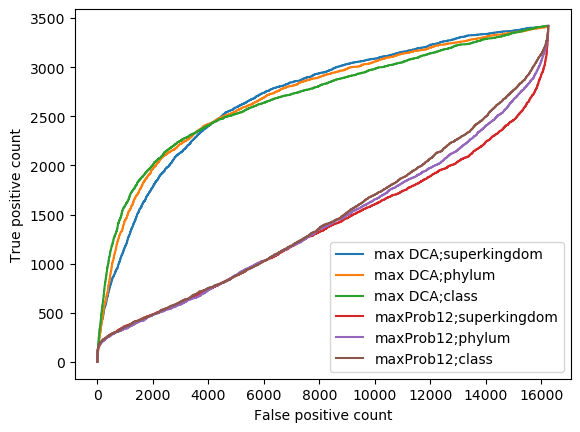

CPU times: user 29.6 s, sys: 4.55 ms, total: 29.6 s
Wall time: 29.6 s


In [58]:
%%time
count_label="count"
step=1
plotType="ROC"

DCA_RocCurve(np.array(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";superkingdom",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";phylum",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";class",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";superkingdom",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";phylum",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";class",step=step,
            plotType=plotType,)


plt.show()


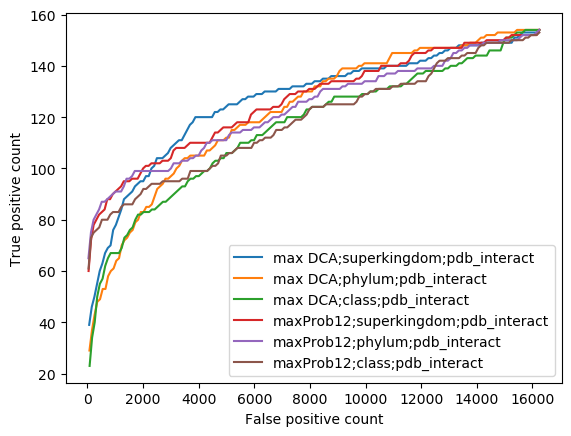

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 202 ms


In [59]:
%%time
count_label="count"
step=100
plotType="ROC"

DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";superkingdom;pdb_interact",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";phylum;pdb_interact",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";class;pdb_interact",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";superkingdom;pdb_interact",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";phylum;pdb_interact",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";class;pdb_interact",step=step,
            plotType=plotType,)


plt.show()


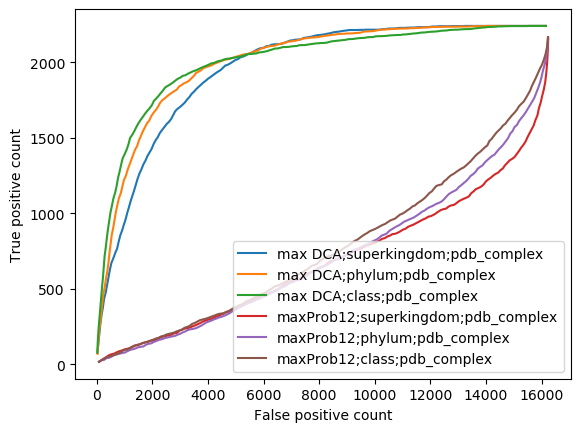

CPU times: user 205 ms, sys: 46 µs, total: 205 ms
Wall time: 204 ms


In [60]:
%%time
count_label="count"
step=100
plotType="ROC"

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";superkingdom;pdb_complex",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";phylum;pdb_complex",step=step,
            plotType=plotType,)
DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";class;pdb_complex",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";superkingdom;pdb_complex",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";phylum;pdb_complex",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";class;pdb_complex",step=step,
            plotType=plotType,)



plt.show()




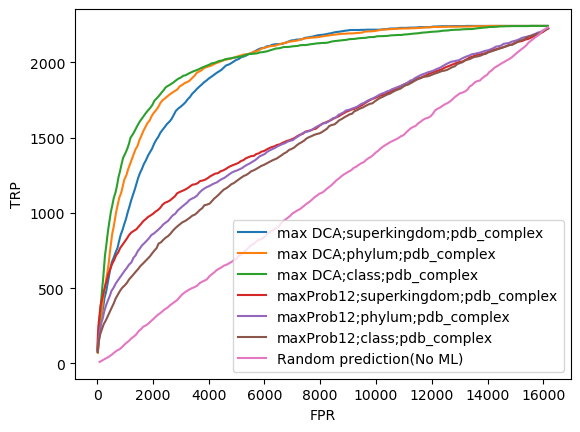

CPU times: user 222 ms, sys: 3.83 ms, total: 226 ms
Wall time: 225 ms


In [61]:
%%time
count_label="count"
step=100
plotType="ROC"

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";superkingdom;pdb_complex",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";phylum;pdb_complex",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";class;pdb_complex",step=step,
            plotType=plotType,)


DCA_RocCurve(1/np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";superkingdom;pdb_complex",step=step,
            plotType=plotType,)


DCA_RocCurve(1/np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";phylum;pdb_complex",step=step,
            plotType=plotType,)

DCA_RocCurve(1/np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";class;pdb_complex",step=step,
            plotType=plotType,)


Random_RocCurve(np.array(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="Random prediction(No ML)",step=step)


plt.show()







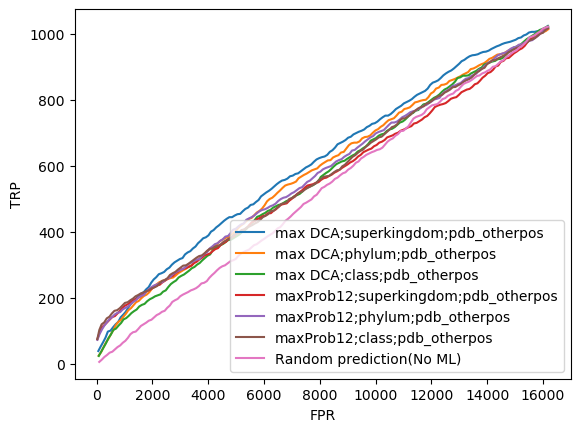

CPU times: user 218 ms, sys: 4.15 ms, total: 222 ms
Wall time: 221 ms


In [62]:
%%time
count_label="count"
step=100
plotType="ROC"

DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";superkingdom;pdb_otherpos",step=step,
            plotType=plotType,)

DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";phylum;pdb_otherpos",step=step,
            plotType=plotType,)
DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
             np.array(pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="max DCA"+";class;pdb_otherpos",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";superkingdom;pdb_otherpos",step=step,
            plotType=plotType,)


DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";phylum;pdb_otherpos",step=step,
            plotType=plotType,)
DCA_RocCurve(np.array(pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
             np.array(pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="maxProb12"+";class;pdb_otherpos",step=step,
            plotType=plotType,)

Random_RocCurve(np.array(pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
             count_label=count_label,legend="Random prediction(No ML)",step=step)



plt.show()


### Supplementary Fig. 3 
adated from http://localhost:8206/lab/tree/code/MNF/notebooks/test_alphafold/test_withLowDCA_integrateAlphafold_phylumeffect_STRINGPhyBalancePhyla_visulization_fullHomologous_oneBestHomologousPP.ipynb

In [63]:
# %%time
# count_label="count"
# step=100
# plotType="ROC"

# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
#              np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="max DCA"+";superkingdom;pdb_interact",step=step,
#             plotType=plotType,)

# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
#              np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="max DCA"+";phylum;pdb_interact",step=step,
#             plotType=plotType,)

# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]), 
#              np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="max DCA"+";class;pdb_interact",step=step,
#             plotType=plotType,)


# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
#              np.array(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="maxProb12"+";superkingdom;pdb_interact",step=step,
#             plotType=plotType,)


# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
#              np.array(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="maxProb12"+";phylum;pdb_interact",step=step,
#             plotType=plotType,)

# DCA_RocCurve(np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"]), 
#              np.array(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"]),
#              count_label=count_label,legend="maxProb12"+";class;pdb_interact",step=step,
#             plotType=plotType,)


# plt.show()


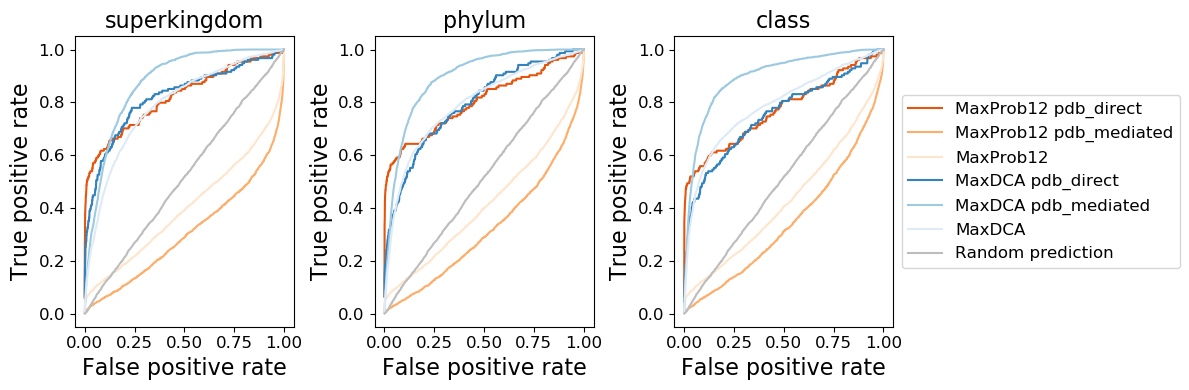

CPU times: user 1.39 s, sys: 192 ms, total: 1.58 s
Wall time: 1.35 s


In [64]:
%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig4 = plt.figure(figsize=(12,4))  #plt.figure(figsize=(12,4))
count_label="rate"
plotType="ROC"  #"PR" #"ROC"
step=10 #10,100,1000
zoom_thres=None

alphafold_prob12_colors=['#e6550d','#fdae6b','#fee6ce']
alphafold_inverseMinDist_colors=['#31a354','#a1d99b','#e5f5e0']
DCA_colors=['#3182bd', '#9ecae1', '#deebf7',]
color_grey="#bdbdbd"

fontdict={"fontsize":16}


axA = plt.subplot(1,3,1)


DCA_RocCurve(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
                randomplot=True,
            fontdict=fontdict)
axA.set_title("superkingdom",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()
# axA.text(-0.2, 1.05, 'A', weight='bold') # for "rate"
# axA.text(-1000, 5800, 'A', weight='bold') # for "count"
# axA.legend(fontsize=8)
axA.legend([],[], frameon=False)



axB =plt.subplot(1,3,2)
DCA_RocCurve(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA ",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
              plotType=plotType,
            randomplot=True,
            fontdict=fontdict)
axB.set_title("phylum",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axB.text(-0.2, 1.05, 'B', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
axB.legend([],[], frameon=False)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()


axC =plt.subplot(1,3,3)
DCA_RocCurve(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
               randomplot=True,
            fontdict=fontdict)
axC.set_title("class",fontsize=16)
# axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
# axA.legend(fontsize=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axC.text(-0.2, 1.05, 'C', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
# axC.legend(fontsize=8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

# plt.xlabel(fontsize=16)
# plt.ylabel(fontsize=16)



plt.tight_layout()
plt.show()
fig4.savefig("/mnt/mnemo5/tao/temp_figures/Fig4.pdf", dpi=600)




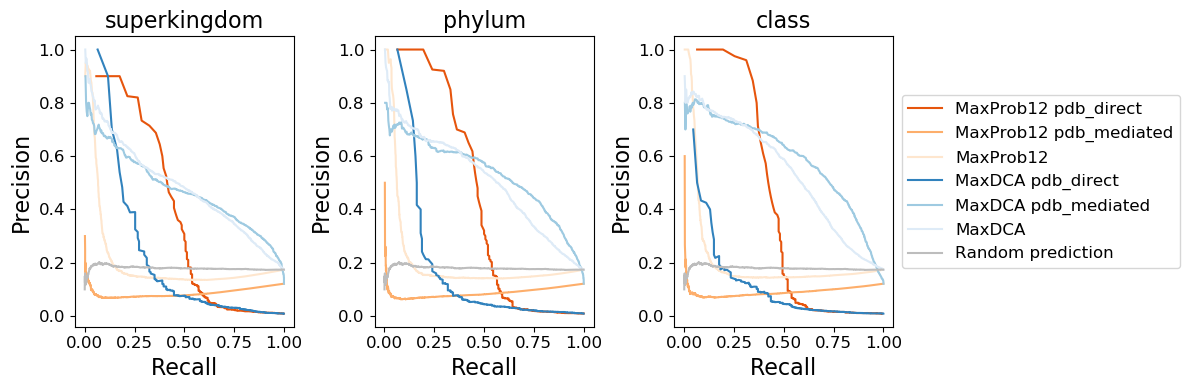

CPU times: user 1.34 s, sys: 201 ms, total: 1.55 s
Wall time: 1.31 s


In [65]:
%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig4 = plt.figure(figsize=(12,4))  #plt.figure(figsize=(12,4))
count_label="rate"
plotType="PR"  #"PR" #"ROC"
step=10 #10,100,1000
zoom_thres=None

alphafold_prob12_colors=['#e6550d','#fdae6b','#fee6ce']
alphafold_inverseMinDist_colors=['#31a354','#a1d99b','#e5f5e0']
DCA_colors=['#3182bd', '#9ecae1', '#deebf7',]
color_grey="#bdbdbd"

fontdict={"fontsize":16}


axA = plt.subplot(1,3,1)


DCA_RocCurve(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
                randomplot=True,
            fontdict=fontdict)
axA.set_title("superkingdom",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()
# axA.text(-0.2, 1.05, 'A', weight='bold') # for "rate"
# axA.text(-1000, 5800, 'A', weight='bold') # for "count"
# axA.legend(fontsize=8)
axA.legend([],[], frameon=False)



axB =plt.subplot(1,3,2)
DCA_RocCurve(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA ",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
              plotType=plotType,
            randomplot=True,
            fontdict=fontdict)
axB.set_title("phylum",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axB.text(-0.2, 1.05, 'B', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
axB.legend([],[], frameon=False)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()


axC =plt.subplot(1,3,3)
DCA_RocCurve(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
               randomplot=True,
            fontdict=fontdict)
axC.set_title("class",fontsize=16)
# axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
# axA.legend(fontsize=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axC.text(-0.2, 1.05, 'C', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
# axC.legend(fontsize=8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

# plt.xlabel(fontsize=16)
# plt.ylabel(fontsize=16)



plt.tight_layout()
plt.show()
fig4.savefig("/mnt/mnemo5/tao/temp_figures/Fig4.pdf", dpi=600)




In [66]:
pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"]

4        1.1596
168      1.5717
226      0.9922
255      0.9580
259      0.9030
          ...  
19664    1.0079
19665    0.4546
19666    0.5271
19667    0.7354
19668    0.9375
Name: max DCA, Length: 16403, dtype: float64

### updated suplementray fig3, with same pos:neg ratio in pdb_direct and pdb_mediated benchmark 

In [67]:
# # pdb_mediated
# # pos number: 2242
# # neg number  16249

# # pdb_direct
# # pos number: 154
# # neg number  16249

# # 154*(16249/2242)
# # 1116.1222123104371

# # 1024*(16249/2242)
# # 7421.487957181088

# same ratio as in code/MNF/notebooks/STRING_Data_11.5/
#                 DownSampleSamePosandNeg_test_phylumeffect_withLowDCA_visulization_fullHomologous_oneBestHomologousPP.ipynb

In [68]:


%%time

samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact",
                            downsample_Ratio=1116,)

samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex",
                            downsample_Ratio=None,)

samePos2NegRatio_pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos",
                            downsample_Ratio=7421,)# here is wrong 

print(samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_otherpos_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame.shape)





len(pos_idx),len(neg_idx) 154 1116
(19669, 10) 1270
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 7421
(19669, 10) 8445
(1270, 10) (18491, 10) (8445, 10)
CPU times: user 6.55 s, sys: 3.58 ms, total: 6.56 s
Wall time: 6.56 s


In [69]:
%%time

samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact",
                            downsample_Ratio=1116,)

samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex",
                            downsample_Ratio=None,)

samePos2NegRatio_pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos",
                            downsample_Ratio=7421,)

print(samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_otherpos_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 1116
(19669, 10) 1270
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 7421
(19669, 10) 8445
(1270, 10) (18491, 10) (8445, 10)
CPU times: user 7.26 s, sys: 15.6 ms, total: 7.28 s
Wall time: 7.28 s


In [70]:
%%time

samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_contact",
                            downsample_Ratio=1116,)

samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="pdb_complex",
                            downsample_Ratio=None,)

samePos2NegRatio_pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame=get_filter_pdbBenchmark(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame,
                                      pdb_interact_PPs,pdb_complex_PPs,
                           pos_lable="other_pos",
                            downsample_Ratio=7421,)

print(samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape,
     samePos2NegRatio_pdb_otherpos_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame.shape)

len(pos_idx),len(neg_idx) 154 1116
(19669, 10) 1270
len(pos_idx),len(neg_idx) 2242 16249
(19669, 10) 18491
len(pos_idx),len(neg_idx) 1024 7421
(19669, 10) 8445
(1270, 10) (18491, 10) (8445, 10)
CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


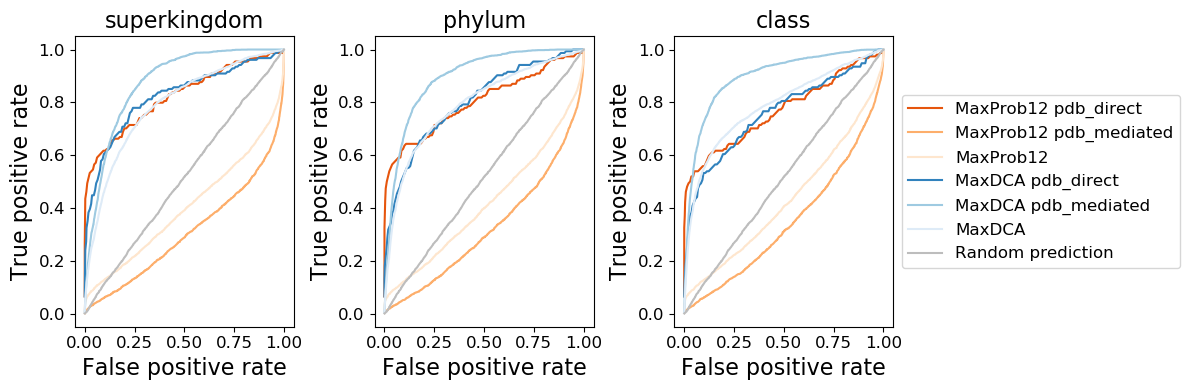

CPU times: user 1.89 s, sys: 208 ms, total: 2.1 s
Wall time: 1.86 s


In [71]:
%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig4 = plt.figure(figsize=(12,4))  #plt.figure(figsize=(12,4))
count_label="rate"
plotType="ROC"  #"PR" #"ROC"
step=10 #10,100,1000
zoom_thres=None

alphafold_prob12_colors=['#e6550d','#fdae6b','#fee6ce']
alphafold_inverseMinDist_colors=['#31a354','#a1d99b','#e5f5e0']
DCA_colors=['#3182bd', '#9ecae1', '#deebf7',]
color_grey="#bdbdbd"

fontdict={"fontsize":16}


axA = plt.subplot(1,3,1)


DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
                randomplot=True,
            fontdict=fontdict)
axA.set_title("superkingdom",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()
# axA.text(-0.2, 1.05, 'A', weight='bold') # for "rate"
# axA.text(-1000, 5800, 'A', weight='bold') # for "count"
# axA.legend(fontsize=8)
axA.legend([],[], frameon=False)



axB =plt.subplot(1,3,2)
DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA ",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
              plotType=plotType,
            randomplot=True,
            fontdict=fontdict)
axB.set_title("phylum",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axB.text(-0.2, 1.05, 'B', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
axB.legend([],[], frameon=False)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()


axC =plt.subplot(1,3,3)
DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
               randomplot=True,
            fontdict=fontdict)
axC.set_title("class",fontsize=16)
# axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
# axA.legend(fontsize=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axC.text(-0.2, 1.05, 'C', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
# axC.legend(fontsize=8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

# plt.xlabel(fontsize=16)
# plt.ylabel(fontsize=16)



plt.tight_layout()
plt.show()
fig4.savefig("/mnt/mnemo5/tao/temp_figures/Fig4.pdf", dpi=600)




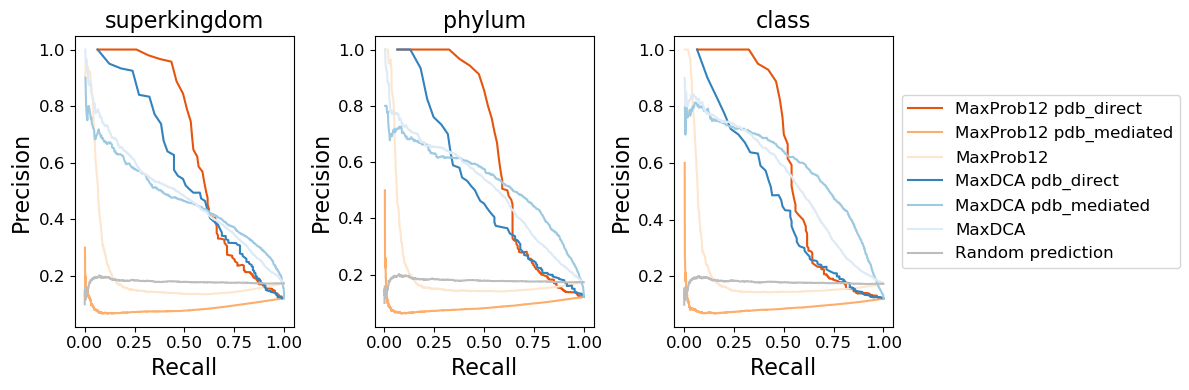

CPU times: user 1.75 s, sys: 204 ms, total: 1.95 s
Wall time: 1.71 s


In [72]:
%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig4 = plt.figure(figsize=(12,4))  #plt.figure(figsize=(12,4))
count_label="rate"
plotType="PR"  #"PR" #"ROC"
step=10 #10,100,1000
zoom_thres=None

alphafold_prob12_colors=['#e6550d','#fdae6b','#fee6ce']
alphafold_inverseMinDist_colors=['#31a354','#a1d99b','#e5f5e0']
DCA_colors=['#3182bd', '#9ecae1', '#deebf7',]
color_grey="#bdbdbd"

fontdict={"fontsize":16}


axA = plt.subplot(1,3,1)


DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog2_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
                randomplot=True,
            fontdict=fontdict)
axA.set_title("superkingdom",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()
# axA.text(-0.2, 1.05, 'A', weight='bold') # for "rate"
# axA.text(-1000, 5800, 'A', weight='bold') # for "count"
# axA.legend(fontsize=8)
axA.legend([],[], frameon=False)



axB =plt.subplot(1,3,2)
DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA ",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1224_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
              plotType=plotType,
            randomplot=True,
            fontdict=fontdict)
axB.set_title("phylum",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axB.text(-0.2, 1.05, 'B', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
axB.legend([],[], frameon=False)
#plt.legend(loc='best')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()


axC =plt.subplot(1,3,3)
DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_direct",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[0],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12 pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[1],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max prob12"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxProb12",step=step,zoom_thres=zoom_thres,
            color=alphafold_prob12_colors[2],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_interact_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_direct",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[0],
            plotType=plotType,
            fontdict=fontdict)

DCA_RocCurve(samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             samePos2NegRatio_pdb_complex_commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA pdb_mediated",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[1],
            plotType=plotType,
            fontdict=fontdict)



DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
             commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="MaxDCA",step=step,zoom_thres=zoom_thres,
            color=DCA_colors[2],
            plotType=plotType,
            fontdict=fontdict)


DCA_RocCurve(commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["max DCA"], 
            commonpp_EggNog1236_minDisAndProb12AndmaxDCAscore_frame["status_numeric"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres,
               color=color_grey,
               plotType=plotType,
               randomplot=True,
            fontdict=fontdict)
axC.set_title("class",fontsize=16)
# axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
# axA.legend(fontsize=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# axC.text(-0.2, 1.05, 'C', weight='bold') # for "rate"
# axB.text(-400, 900, 'B', weight='bold')
# axC.legend(fontsize=8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

# plt.xlabel(fontsize=16)
# plt.ylabel(fontsize=16)



plt.tight_layout()
plt.show()
fig4.savefig("/mnt/mnemo5/tao/temp_figures/Fig4.pdf", dpi=600)


